# Movement Recognition

This notebook contains the main code for the movement recognition tasks. It loads the participant data, preprocesses it and uses this data to train the different models either on the execution task, or on the observation task.

### Import librairies

In [1]:
from utils import *
from dataset import *
from constants import *
from models.BaseModels import *
from models.DeepModels import *
from models.DeepUtils import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from dataset import Participant
from torch.utils.data import DataLoader

# Reproducibility
seed_num = RANDOM_STATE # This seed will be used for all random number generators
torch.use_deterministic_algorithms(True) # PyTorch will use deterministic algorithms fro operations with stochastic behavior like dropout
random.seed(seed_num) # Python's random will use seed_num
np.random.seed(seed_num) # NumPy's random number generator will use seed_num
torch.manual_seed(seed_num) # PyTorch's random number will use seed_num

### Data loading

Change here the participant to load.

In [2]:
part_name = 's6'
use_saved = True

In [3]:
if use_saved and os.path.exists(f'saved/{part_name}.pkl'):
    participant = Participant.load_from_pickle(f'saved/{part_name}.pkl')
else:
    participant = Participant(part_name, data_path=DATA_PATH_NOTEBOOK, alpha=ALPHA)
    saved_dir = os.path.join(os.getcwd(), 'saved')
    if not os.path.exists(saved_dir):
        os.makedirs(saved_dir)
    with open(f'saved/{part_name}.pkl', 'wb') as f:
        pickle.dump(participant, f, pickle.HIGHEST_PROTOCOL)

In [4]:
test_size = 0.3
pca_expl_var = 0.95

### Possible hyperparameters for MLP models.

In [5]:
models = {
    '8_8_01': {
        'layers': (8, 8),
        'lr': 0.1
    },
    '8_16_01': {
        'layers': (8, 16),
        'lr': 0.1
    },
    '16_16_01': {
        'layers': (16, 16),
        'lr': 0.1
    },
    '32_16_01': {
        'layers': (32, 16),
        'lr': 0.1
    }, # more complex, might require higher learning rate
    '32_16_02': {
        'layers': (32, 16),
        'lr': 0.2
    }
}

## Execution

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [6]:
if use_saved and os.path.exists(f'saved/ex_features_{part_name}_mvt.h5'):
    ex_features = pd.read_hdf(f'saved/ex_features_{part_name}_mvt.h5', 'df')
else:
    ex_features = participant.get_features_all_sessions_mvt('E')
    ex_features.to_hdf(f'saved/ex_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [7]:
print(f'The dataset contains {ex_features.shape[0]} samples and {ex_features.shape[1]} features.')
print(f'The {len(participant.relevant_channels_ex)} relevant channels are located in the following locations:')
regions = [participant.channels_locations[i] for i in [channel.idx for channel in participant.relevant_channels_ex]]
channels_per_regions = {}
for region in set(regions):
    channels_per_regions[region] = regions.count(region)
print(channels_per_regions)

The dataset contains 128 samples and 4897 features.
The 68 relevant channels are located in the following locations:
{'WM_precentral': 6, 'WM_insula': 1, 'superiorfrontal': 5, 'WM_paracentral': 1, 'caudalmiddlefrontal': 4, 'precentral': 26, 'supramarginal': 3, 'paracentral': 3, 'postcentral': 16, 'insula': 3}


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [8]:
if use_saved and os.path.exists(f'saved/ex_baseline_features_{part_name}_mvt.h5'):
    ex_baseline_features = pd.read_hdf(f'saved/ex_baseline_features_{part_name}_mvt.h5', 'df')
else:
    ex_baseline_features = participant.get_features_all_sessions_unresponsive(movtype='E')
    ex_baseline_features.to_hdf(f'saved/ex_baseline_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [9]:
print(f'The baseline dataset contains {ex_baseline_features.shape[0]} samples and {ex_baseline_features.shape[1]} features.')

The baseline dataset contains 128 samples and 2737 features.


In [10]:
accuracies_ex = {}
accuracies_ex_baseline = {}

In [11]:
X = ex_baseline_features.drop('label', axis=1)
y = ex_baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model on the baseline features (Logistic Regression)

In [12]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['LR'] = accuracy

Accuracy: 0.64


#### With PCA

In [13]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['LR PCA'] = accuracy

Accuracy: 0.59


### Train a model (SVM)

In [14]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['SVM'] = accuracy

Accuracy: 0.62


#### With PCA

In [15]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [16]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex_baseline['RF'] = accuracy

Accuracy: 0.56


### Train a model (Multi-Layer Perceptron)

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 1e-1, save_path=f'saved/mlpMRexbaseline_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader, verbose=False)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Model 8_8_01 Validation Loss: 0.6838
Model 8_16_01 Validation Loss: 0.6926
Model 16_16_01 Validation Loss: 0.6976
Model 32_16_01 Validation Loss: 0.5134
Model 32_16_02 Validation Loss: 0.6814


For s6, the best model has 2 layers of 8 neurons and a learning rate of 0.1.

In [19]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRexbaseline_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_ex_baseline['MLP'] = acc

Accuracy: 0.45


## Let's now do the analysis for the responsive channels

In [20]:
X = ex_features.drop('label', axis=1)
y = ex_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [21]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['LR'] = accuracy

Accuracy: 0.77


#### With PCA

In [22]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['LR PCA'] = accuracy

Accuracy: 0.69


### Train a model (SVM)

In [23]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['SVM'] = accuracy

Accuracy: 0.62


#### With PCA

In [24]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [25]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_ex['RF'] = accuracy

Accuracy: 0.56


### Train a model (Multi-Layer Perceptron)

In [26]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

We train the MLP with different layers and learning rate, and test on the model with the lowest final accuracy loss.

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpMRex_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader, verbose=False)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Model 8_8_01 Validation Loss: 0.8105
Model 8_16_01 Validation Loss: 0.6548
Model 16_16_01 Validation Loss: 1.3740
Model 32_16_01 Validation Loss: 0.6861
Model 32_16_02 Validation Loss: 0.7126


The best model has 2 layers of 8 and 16 neurons and a learning rate of 0.1.

In [28]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_16_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRex_8_16_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_ex['MLP'] = acc

Accuracy: 0.45


## Observation

<span style='color: red'>WARNING</span>: computing all features takes around 7 minutes (Intel Core i7-7700K)

In [29]:
if use_saved and os.path.exists(f'saved/obs_features_{part_name}_mvt.h5'):
    obs_features = pd.read_hdf(f'saved/obs_features_{part_name}_mvt.h5', 'df')
else:
    obs_features = participant.get_features_all_sessions_mvt('O')
    obs_features.to_hdf(f'saved/obs_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [30]:
print(f'The dataset contains {obs_features.shape[0]} samples and {obs_features.shape[1]} features.')

The dataset contains 128 samples and 3673 features.


Let's create a baseline by taking the same number of channels, but without checking whether they are responsive:

In [31]:
if use_saved and os.path.exists(f'saved/obs_baseline_features_{part_name}_mvt.h5'):
    obs_baseline_features = pd.read_hdf(f'saved/obs_baseline_features_{part_name}_mvt.h5', 'df')
else:
    obs_baseline_features = participant.get_features_all_sessions_unresponsive(movtype='O')
    obs_baseline_features.to_hdf(f'saved/obs_baseline_features_{part_name}_mvt.h5', 'df', mode='w', data_columns=True)

In [32]:
print(f'The baseline dataset contains {ex_baseline_features.shape[0]} samples and {ex_baseline_features.shape[1]} features.')

The baseline dataset contains 128 samples and 2737 features.


In [33]:
accuracies_obs = {}
accuracies_obs_baseline = {}

### Train a model on the baseline features (Logistic Regression)

In [34]:
X = obs_baseline_features.drop('label', axis=1)
y = obs_baseline_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['LR'] = accuracy

Accuracy: 0.49


#### With PCA

In [35]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['LR PCA'] = accuracy

Accuracy: 0.49


### Train a model (SVM)

In [36]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['SVM'] = accuracy

Accuracy: 0.44


#### With PCA

In [37]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['SVM PCA'] = accuracy

Accuracy: 0.54


### Train a model (Random Forest)

In [38]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs_baseline['RF'] = accuracy

Accuracy: 0.54


### Train a model (Multi-Layer Perceptron)

In [39]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpMRobsbaseline_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader, verbose=False)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Model 8_8_01 Validation Loss: 0.7093
Model 8_16_01 Validation Loss: 0.7119
Model 16_16_01 Validation Loss: 0.6958
Model 32_16_01 Validation Loss: 0.7701
Model 32_16_02 Validation Loss: 0.7915


The best model has two layers of 8 neurons and a learning rate of 0.1.

In [41]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_8_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRobsbaseline_8_8_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_obs_baseline['MLP'] = acc

Accuracy: 0.60


## Let's now do the analysis for the responsive channels

In [42]:
X = obs_features.drop('label', axis=1)
y = obs_features['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE)

### Train a model (Logistic Regression)

In [43]:
logreg = LogisticRegressionModel()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['LR'] = accuracy

Accuracy: 0.62


#### With PCA

In [44]:
logreg = LogisticRegressionModel(use_pca=True, expl_var=0.95)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['LR PCA'] = accuracy

Accuracy: 0.51


### Train a model (SVM)

In [45]:
svm = SVMModel()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['SVM'] = accuracy

Accuracy: 0.51


#### With PCA

In [46]:
svm = SVMModel(use_pca=True, expl_var=0.95)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['SVM PCA'] = accuracy

Accuracy: 0.56


### Train a model (Random Forest)

In [47]:
rf = RandomForestModel()
rf.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies_obs['RF'] = accuracy

Accuracy: 0.56


### Train a model (Multi-Layer Perceptron)

In [48]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

valid_losses = {}
for model_name, params in models.items():
    mlp = MLP(X_train.shape[1], 2, layers=params['layers'])
    trainset = DfDataset(X_train, y_train)
    valset = DfDataset(X_val, y_val)
    train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
    val_loader = DataLoader(valset, batch_size=4, shuffle=False)

    trainer = Trainer(mlp, params['lr'], 10, 1e-2, save_path=f'saved/mlpMRobs_{model_name}.pth', device=device)
    valid_losses[model_name] = trainer.train(train_loader, val_loader, verbose=False)

for model_name in models.keys():
    print(f'Model {model_name} Validation Loss: {valid_losses[model_name]:.4f}')

Model 8_8_01 Validation Loss: 0.7023
Model 8_16_01 Validation Loss: 0.7024
Model 16_16_01 Validation Loss: 0.6762
Model 32_16_01 Validation Loss: 0.6935
Model 32_16_02 Validation Loss: 28.8140


The best model has 2 layers of 8 and 16 neurons and a learning rate of 0.1.

In [50]:
mlp = MLP(X_train.shape[1], 2, layers=models['8_16_01']['layers'])
mlp.load_state_dict(torch.load('saved/mlpMRobs_8_16_01.pth'))
mlp.eval()

testset = DfDataset(X_test, y_test)
acc = 0
for input, label in testset:
    pred = mlp(input)
    if torch.argmax(pred) == label:
        acc += 1

acc /= len(testset)
print(f"Accuracy: {acc:.2f}")

accuracies_obs['MLP'] = acc

Accuracy: 0.60


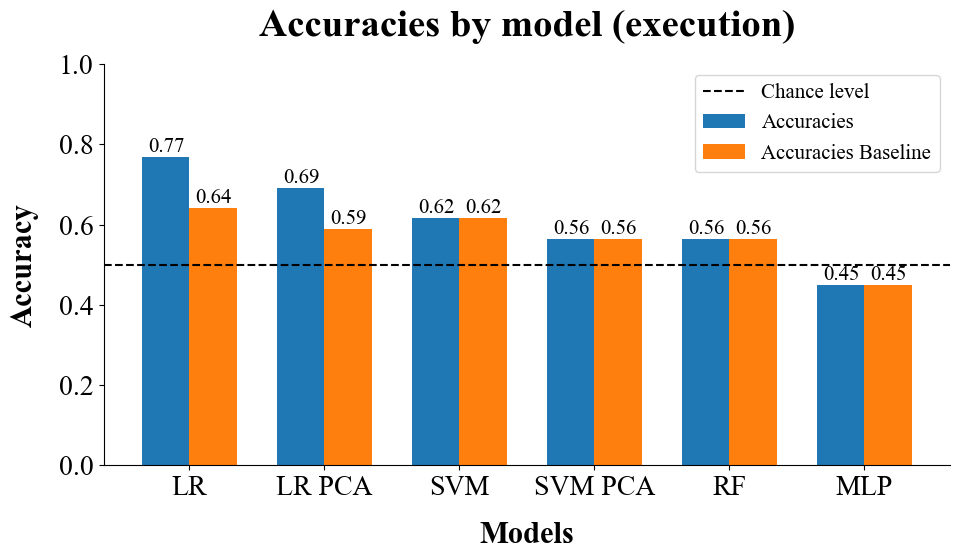

In [51]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies_ex.keys()

dataset_values = [accuracies_ex[model] for model in models]
baseline_values = [accuracies_ex_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (execution)')

ax.set_ylim(0,1)

ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
plt.axhline(0.5, linestyle='--', color='k', label='Chance level')
plt.legend(fontsize=15)

plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_ex.png')
plt.show()


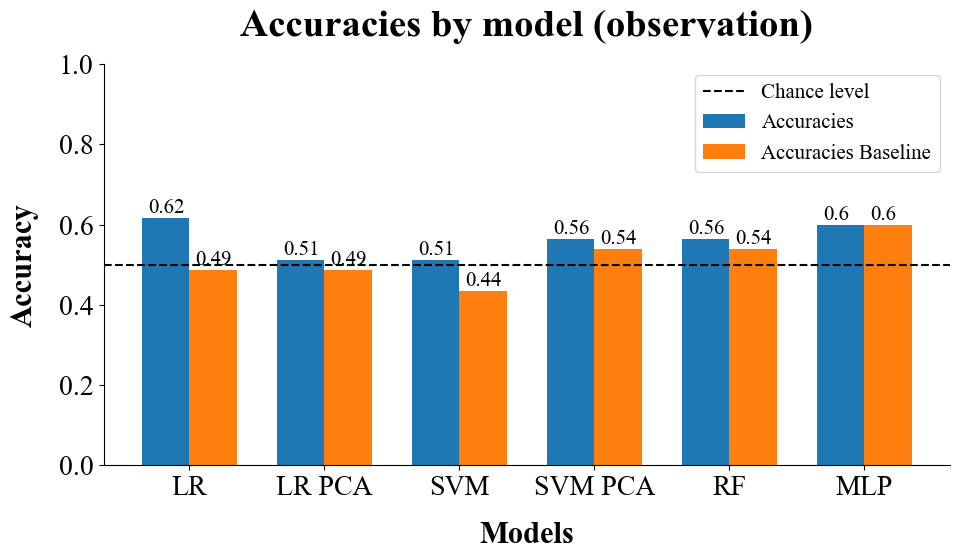

In [52]:
# General
plt.rcParams["font.family"] = "Times New Roman"
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight = 'bold', titlepad = 20)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight = 'bold', labelpad = 15)   # fontsize of the x and y labels    
plt.rc('xtick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE, direction = 'out')    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes.spines', top=False, right=False)  # Removing the top and right spines   

models = accuracies_obs.keys()

dataset_values = [accuracies_obs[model] for model in models]
baseline_values = [accuracies_obs_baseline[model] for model in models]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, dataset_values, width, label='Accuracies')
bars2 = ax.bar(x + width/2, baseline_values, width, label='Accuracies Baseline')

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')
ax.set_title('Accuracies by model (observation)')

ax.set_ylim(0,1)

ax.legend()

for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)
    
for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/8, yval, round(yval, 2), va='bottom', fontsize=15)

plt.axhline(0.5, linestyle='--', color='k', label='Chance level')
plt.legend(fontsize=15)
  
plt.tight_layout()
saved_dir = os.path.join(os.getcwd(), 'figures')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)
plt.savefig('figures/accuracies_obs.png')
plt.show()
